# Debugging for dataset
## script
    - Make sure the dataset script is in `vos/dataset/`
    - And this notebook is working on `COCO.py` or `ECSSD.py`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

from vos.utils.helpers import stack_images, stack_masks
from vos.datasets.COCO import COCO
from vos.datasets.ECSSD import ECSSD
from vos.datasets.MSRA10K import MSRA10K
from vos.datasets.SBD import SBD
from vos.datasets.VOC import VOCSegmentation

In [53]:
cocoroot = "/p300/videoObjSeg_dataset/COCO-2017-train"
cocod = dataset = COCO(cocoroot, mode= "train", max_n_objects= 8, sort_anns= True)

# ecssdroot = "/p300/videoObjSeg_dataset/ECSSD"
# dataset = ECSSD(ecssdroot)

# msraroot = "/p300/videoObjSeg_dataset/MSRA10K_Imgs_GT"
# dataset = MSRA10K(msraroot)

# sbdroot = "/p300/videoObjSeg_dataset/SBD"
# dataset = SBD(sbdroot)

# vocroot = "/p300/videoObjSeg_dataset/VOC"
# dataset = VOCSegmentation(vocroot)

print(len(dataset))

loading annotations into memory...
Done (t=15.32s)
creating index...
index created!
118287


Index:  109108


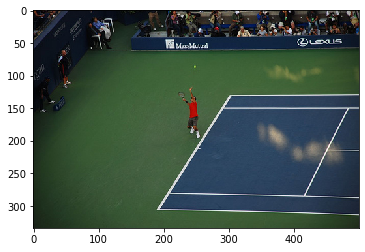

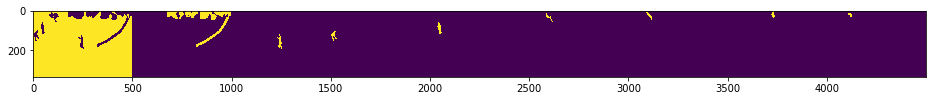

Index:  92147


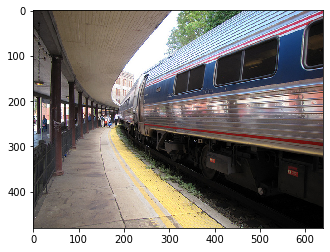

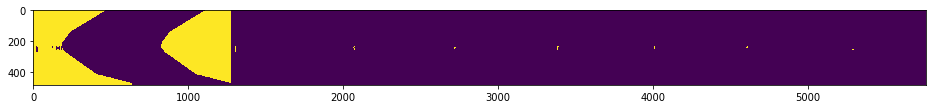

In [58]:
# for _ in range(50):
for idx in [109108, 92147]:
    # idx = np.random.choice(len(dataset), 1)[0]
    # idx = 3127*4+2-11000-1464
    # idx = 109108
    print("Index: ", idx)
    data = dataset[idx]
    # data = dataset[0]
#     for k, v in data.items():
#         print(k, v.shape)

    image = data["image"].numpy().transpose(1,2,0)
    mask = data["mask"].numpy().transpose(1,2,0)

#     print(data["n_objects"], mask.shape)
    no = data["n_objects"]
    H, W, N = mask.shape
    plt.imshow(image)

    s_masks = stack_masks(
        np.expand_dims(mask.transpose(2,0,1), 0)
    )
#     print(s_masks[0,0].shape)
    plt.figure(figsize= (16, 6))
    plt.imshow(s_masks[0,0])
    plt.show()

## Dealing with contour image (make them into mask)

Done, don't do the next cell

In [ ]:
import cv2
converted_mask = np.zeros_like(mask[:,:,1], dtype= np.uint8)
contours, h = cv2.findContours(mask[:,:,1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
filled_contours = cv2.drawContours(converted_mask, contours, -1, 1, -1)
plt.imshow(filled_contours)

#### Bug confirmed (from COCO)
    Wrong masked in channel whose idx is greater than 1

In [16]:
import skimage.io as io

In [17]:
# idx = np.random.choice(len(cocod), 1)[0]

img = cocod.coco.loadImgs(cocod.imgIds[idx])[0]
# This image is in (H, W, C) shape
image = io.imread('%s/images/%s'%(
    cocod._root,
    img['file_name']
)).astype(np.float32) / 255

annIds = cocod.coco.getAnnIds(imgIds= img["id"])
anns = cocod.coco.loadAnns(annIds)

anns.sort(key= lambda x: x["area"], reverse= True)

ann = anns[0]
ann_mask = cocod.coco.annToMask(ann)
H, W = ann_mask.shape
print(ann_mask.shape, type(anns))
plt.imshow(image)

IndexError: list index out of range

In [ ]:
print(ann.keys())
print("area: {}".format(ann["area"]))
print("area fraction: {}".format(ann["area"] / np.prod(image.shape)))
plt.imshow(ann_mask, cmap= "gray")

In [ ]:
mask = np.empty((H, W, 1), dtype= np.uint8)
print((mask == 0).all())
mask[:, :, 0] |= ann_mask
plt.imshow(mask[:,:,0], cmap= "gray")

In [ ]:
mask = np.zeros((H, W, 1), dtype= np.uint8)
print((mask == 0).all())
mask[:, :, 0] |= ann_mask
plt.imshow(mask[:,:,0], cmap= "gray")